In [1]:
import pandas as pd
import re, string
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import gensim
import nltk as nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from scipy.spatial.distance import jaccard

### shortening the dataset

In [2]:
rating_df = pd.read_csv('data/rating.csv')
rating_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7813737 entries, 0 to 7813736
Data columns (total 3 columns):
 #   Column    Dtype
---  ------    -----
 0   user_id   int64
 1   anime_id  int64
 2   rating    int64
dtypes: int64(3)
memory usage: 178.8 MB


In [3]:
anime_df = pd.read_csv('data/anime.csv')
anime_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12294 entries, 0 to 12293
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   anime_id  12294 non-null  int64  
 1   name      12294 non-null  object 
 2   genre     12232 non-null  object 
 3   type      12269 non-null  object 
 4   episodes  12294 non-null  object 
 5   rating    12064 non-null  float64
 6   members   12294 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 672.5+ KB


In [4]:
unique_in_amime_df=set(anime_df.anime_id.unique())
unique_in_rating_df=set(rating_df.anime_id.unique())
present_in_both=unique_in_amime_df.intersection(unique_in_rating_df)
print(f'Number of unique animes in the anime dataset: {len(unique_in_amime_df)}')
print(f'Number of unique animes in the rating dataset: {len(unique_in_rating_df)}')
print(f'Number of unique animes in both datasets: {len(present_in_both)}')

Number of unique animes in the anime dataset: 12294
Number of unique animes in the rating dataset: 11200
Number of unique animes in both datasets: 11197


In [5]:
value_cnts=rating_df[rating_df.anime_id.isin(present_in_both)].anime_id.value_counts()
value_cnts

anime_id
1535     39340
11757    30583
16498    29584
1575     27718
226      27506
         ...  
13165        1
13103        1
12981        1
12905        1
30738        1
Name: count, Length: 11197, dtype: int64

In [6]:
import random
random.seed(820)
selected_animes = list(value_cnts.index[:100])
selected_animes.extend(random.sample(list(value_cnts.index[100:]), 900))
len(selected_animes)

1000

In [7]:
rating_df[rating_df.anime_id.isin(selected_animes)].to_csv('data/rating_shortened.csv', index=False)

In [8]:
shortened_rating_df = pd.read_csv('data/rating_shortened.csv')
shortened_rating_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2084435 entries, 0 to 2084434
Data columns (total 3 columns):
 #   Column    Dtype
---  ------    -----
 0   user_id   int64
 1   anime_id  int64
 2   rating    int64
dtypes: int64(3)
memory usage: 47.7 MB


In [9]:
anime_df[anime_df.anime_id.isin(selected_animes)].to_csv('data/anime_shortened.csv', index=False)

In [10]:
shortened_anime_df = pd.read_csv('data/anime_shortened.csv')
shortened_anime_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   anime_id  1000 non-null   int64  
 1   name      1000 non-null   object 
 2   genre     1000 non-null   object 
 3   type      1000 non-null   object 
 4   episodes  1000 non-null   int64  
 5   rating    1000 non-null   float64
 6   members   1000 non-null   int64  
dtypes: float64(1), int64(3), object(3)
memory usage: 54.8+ KB


## creating similarity matrix

In [11]:
anime_df = pd.read_csv('data/anime_shortened.csv')
anime_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   anime_id  1000 non-null   int64  
 1   name      1000 non-null   object 
 2   genre     1000 non-null   object 
 3   type      1000 non-null   object 
 4   episodes  1000 non-null   int64  
 5   rating    1000 non-null   float64
 6   members   1000 non-null   int64  
dtypes: float64(1), int64(3), object(3)
memory usage: 54.8+ KB


In [12]:
anime_df.head()

anime_id                                name  \
0      5114    Fullmetal Alchemist: Brotherhood   
1      9253                         Steins;Gate   
2       820                Ginga Eiyuu Densetsu   
3      4181                Clannad: After Story   
4      2904  Code Geass: Hangyaku no Lelouch R2   

                                               genre type  episodes  rating  \
0  Action, Adventure, Drama, Fantasy, Magic, Mili...   TV        64    9.26   
1                                   Sci-Fi, Thriller   TV        24    9.17   
2                     Drama, Military, Sci-Fi, Space  OVA       110    9.11   
3  Drama, Fantasy, Romance, Slice of Life, Supern...   TV        24    9.06   
4  Action, Drama, Mecha, Military, Sci-Fi, Super ...   TV        25    8.98   

   members  
0   793665  
1   673572  
2    80679  
3   456749  
4   572888

In [13]:
anime_df.anime_id.nunique()

1000

In [14]:
anime_df[anime_df.isna().any(axis=1)]

Empty DataFrame
Columns: [anime_id, name, genre, type, episodes, rating, members]
Index: []

### genre similarity

In [15]:
non_null_genre_indices=anime_df[anime_df.genre.notna()].index

In [16]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [17]:
def tokenize_anime_genres(title, punct='!"#$%&\'()*+,./:;<=>?@[\\]^_`{|}~'):
    # remove numbers
    title=re.sub(r'\d+','',title)
    # remove punctuation 
    translator=str.maketrans(punct, ' '*len(punct))
    title=title.translate(translator)
    # convert to lowercase
    title=title.lower()
    # Get English stop words
    stop_words = set(stopwords.words('english'))
    # Tokenize the text
    word_tokens = word_tokenize(title)
    # Remove English stop words and numbers
    word_tokens = [w for w in word_tokens if (not w.lower() in stop_words) and (not w.isnumeric())]
    return word_tokens

In [18]:
all_genres_tokenized = [tokenize_anime_genres(anime_df.at[i,'genre'], punct=',') for i in anime_df[anime_df.genre.notna()].index]

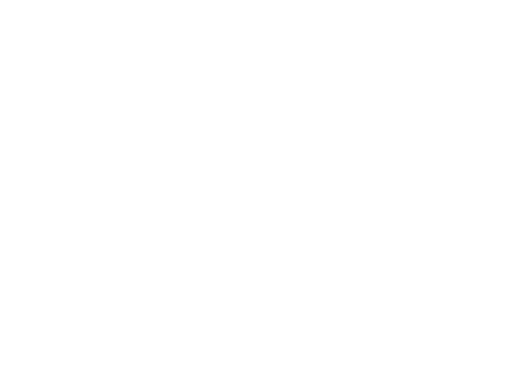

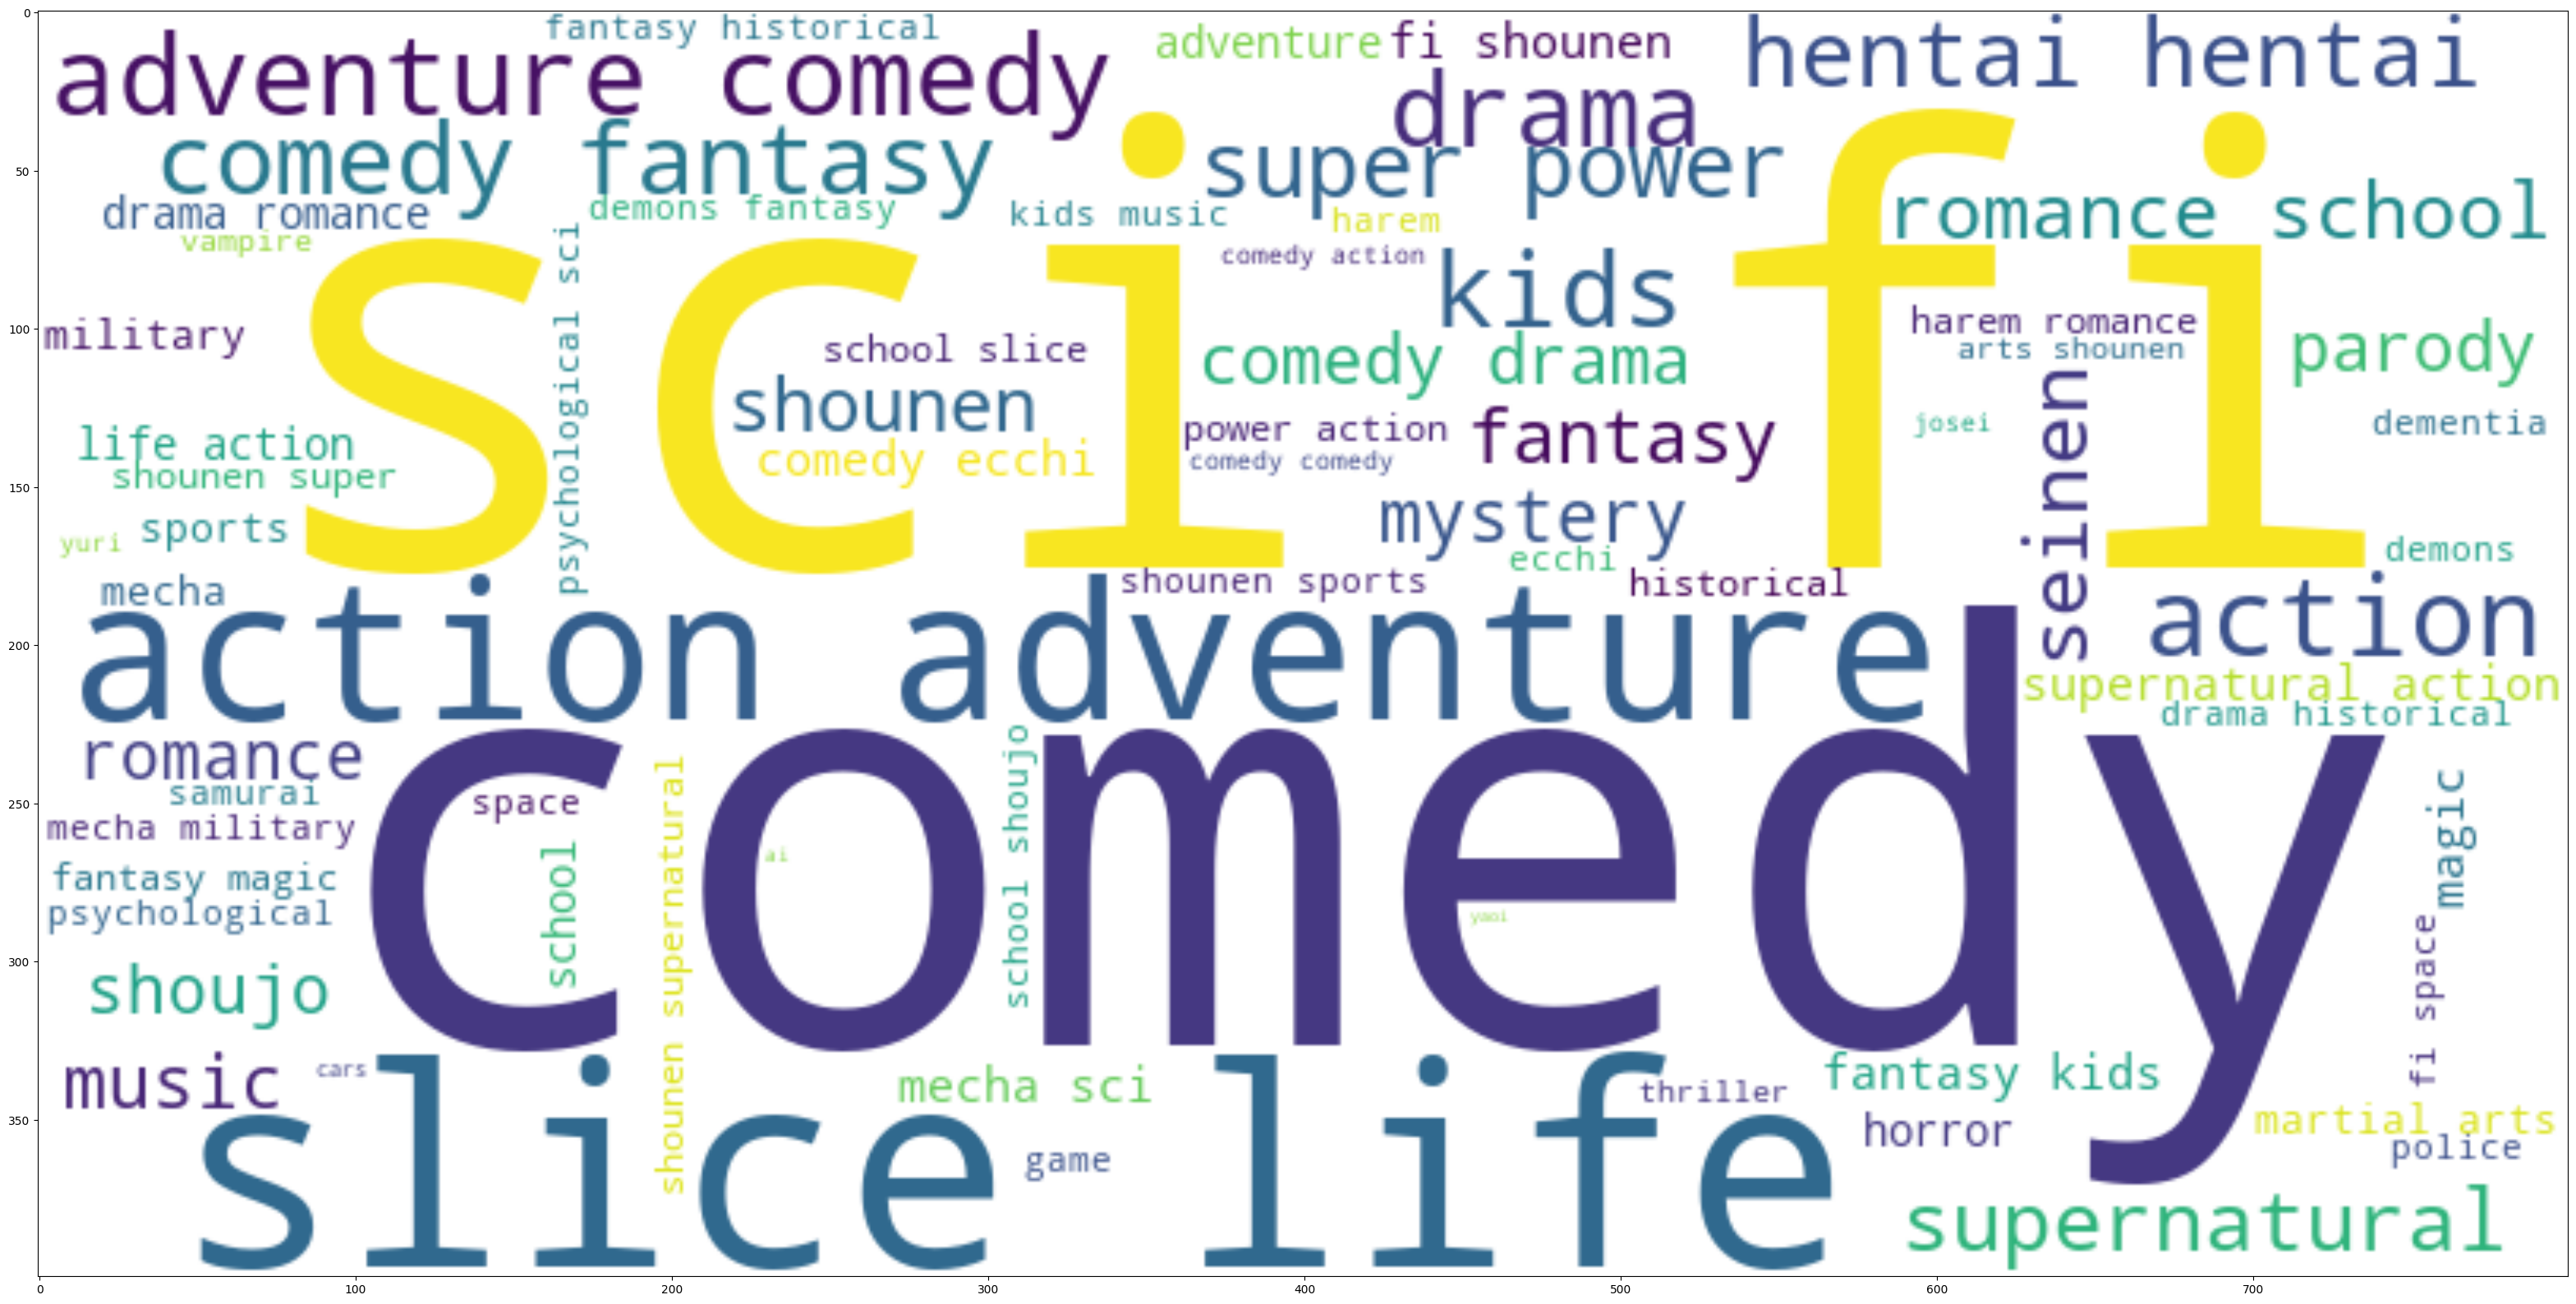

In [19]:
genres_combined=" ".join(el for list in all_genres_tokenized for el in list)
wordcloud = WordCloud(background_color="white", width=800, height=400)
wordcloud.generate(genres_combined)
# Disable axis display
plt.axis("off")
# Create a new figure with a specified size
plt.figure(figsize=(40,20))
# Adjust the layout to ensure tight spacing
plt.tight_layout(pad=0)
# Display the word cloud image with bilinear interpolation
plt.imshow(wordcloud, interpolation='bilinear')

wordcloud.to_file('anime_genres_wordcloud.png');

In [20]:
tokens_dict = gensim.corpora.Dictionary(all_genres_tokenized)
print(tokens_dict.token2id)

{'action': 0, 'adventure': 1, 'drama': 2, 'fantasy': 3, 'magic': 4, 'military': 5, 'shounen': 6, 'sci-fi': 7, 'thriller': 8, 'space': 9, 'life': 10, 'romance': 11, 'slice': 12, 'supernatural': 13, 'mecha': 14, 'power': 15, 'super': 16, 'school': 17, 'arts': 18, 'historical': 19, 'martial': 20, 'samurai': 21, 'comedy': 22, 'parody': 23, 'seinen': 24, 'mystery': 25, 'police': 26, 'psychological': 27, 'horror': 28, 'josei': 29, 'sports': 30, 'ecchi': 31, 'game': 32, 'vampire': 33, 'harem': 34, 'shoujo': 35, 'demons': 36, 'dementia': 37, 'cars': 38, 'music': 39, 'ai': 40, 'kids': 41, 'hentai': 42, 'yaoi': 43, 'yuri': 44}


In [21]:
genre_list=list(tokens_dict.token2id.keys())
genre_df=pd.DataFrame(np.zeros(shape=(anime_df.shape[0], len(genre_list))))
genre_df.columns=['genre_'+el for el in genre_list]
genre_df['anime_id']=anime_df.anime_id
genre_df

genre_action  genre_adventure  genre_drama  genre_fantasy  genre_magic  \
0             0.0              0.0          0.0            0.0          0.0   
1             0.0              0.0          0.0            0.0          0.0   
2             0.0              0.0          0.0            0.0          0.0   
3             0.0              0.0          0.0            0.0          0.0   
4             0.0              0.0          0.0            0.0          0.0   
..            ...              ...          ...            ...          ...   
995           0.0              0.0          0.0            0.0          0.0   
996           0.0              0.0          0.0            0.0          0.0   
997           0.0              0.0          0.0            0.0          0.0   
998           0.0              0.0          0.0            0.0          0.0   
999           0.0              0.0          0.0            0.0          0.0   

     genre_military  genre_shounen  genre_sci-fi  genre_thriller  genre_space  \
0               0.0            0.0           0.0             0.0          0.0   
1               0.0            0.0           0.0             0.0          0.0   
2               0.0            0.0           0.0             0.0          0.0   
3               0.0            0.0           0.0             0.0          0.0   
4               0.0            0.0           0.0             0.0          0.0   
..              ...            ...           ...             ...          ...   
995             0.0            0.0           0.0             0.0          0.0   
996             0.0            0.0           0.0             0.0          0.0   
997             0.0            0.0           0.0             0.0          0.0   
998             0.0            0.0           0.0             0.0          0.0   
999             0.0            0.0           0.0             0.0          0.0   

     ...  genre_demons  genre_dementia  genre_cars  genre_music  genre_ai  \
0    ...           0.0             0.0         0.0          0.0       0.0   
1    ...           0.0             0.0         0.0          0.0       0.0   
2    ...           0.0             0.0         0.0          0.0       0.0   
3    ...           0.0             0.0         0.0          0.0       0.0   
4    ...           0.0             0.0         0.0          0.0       0.0   
..   ...           ...             ...         ...          ...       ...   
995  ...           0.0             0.0         0.0          0.0       0.0   
996  ...           0.0             0.0         0.0          0.0       0.0   
997  ...           0.0             0.0         0.0          0.0       0.0   
998  ...           0.0             0.0         0.0          0.0       0.0   
999  ...           0.0             0.0         0.0          0.0       0.0   

     genre_kids  genre_hentai  genre_yaoi  genre_yuri  anime_id  
0           0.0           0.0         0.0         0.0      5114  
1           0.0           0.0         0.0         0.0      9253  
2           0.0           0.0         0.0         0.0       820  
3           0.0           0.0         0.0         0.0      4181  
4           0.0           0.0         0.0         0.0      2904  
..          ...           ...         ...         ...       ...  
995         0.0           0.0         0.0         0.0     18483  
996         0.0           0.0         0.0         0.0     14207  
997         0.0           0.0         0.0         0.0     18197  
998         0.0           0.0         0.0         0.0     10368  
999         0.0           0.0         0.0         0.0     26081  

[1000 rows x 46 columns]

In [22]:
for (genre_tokenized_index, df_index) in enumerate(non_null_genre_indices):
    for genre in genre_list:
        if genre in all_genres_tokenized[genre_tokenized_index]:
            genre_df.at[df_index, 'genre_'+genre]=1.0

In [23]:
genre_df.to_csv("data/genre.csv", index=False)

In [24]:
def get_genre_similarity(id_one, id_two):
    base = genre_df[genre_df.anime_id == id_one].copy()
    compare = genre_df[genre_df.anime_id == id_two].copy()
    base['type'] = 'base'
    compare['type'] = 'compare'
    return 1 - jaccard(base.values[0,:-1], compare.values[0,:-1])

### type similarity

In [25]:
anime_df.type.value_counts()

type
TV         338
OVA        272
Movie      175
Special    132
ONA         45
Music       38
Name: count, dtype: int64

In [26]:
anime_df[anime_df.type=='Music'].head()

anime_id                                               name  \
63        731  Interstella5555: The 5tory of The 5ecret 5tar ...   
174      9930                                      Snow Halation   
272      4705         Tengen Toppa Gurren Lagann: Parallel Works   
321     11487                                 Sekiranun Graffiti   
356      2274                                CLAMP in Wonderland   

                               genre   type  episodes  rating  members  
63   Adventure, Drama, Music, Sci-Fi  Music         1    8.17    31464  
174                            Music  Music         1    7.61     8731  
272                            Music  Music         8    7.27    22213  
321                            Music  Music         1    7.11     4014  
356                            Music  Music         1    6.99    12267

In [27]:
anime_df[anime_df.type=='Music'].genre.value_counts()

genre
Music                                        18
Kids, Music                                   6
Fantasy, Music                                3
Music, School                                 2
Adventure, Drama, Music, Sci-Fi               1
Adventure, Music, Police, Romance, Sci-Fi     1
Drama, Music, Romance, Slice of Life          1
Action, Music, Sci-Fi                         1
Kids, Music, Slice of Life                    1
Comedy, Kids, Music                           1
Music, Supernatural, Vampire                  1
Dementia, Music                               1
Comedy, Dementia, Music                       1
Name: count, dtype: int64

In [28]:
def get_type_similarity(id_one, id_two):
    type_one = anime_df[anime_df.anime_id == id_one].values[0,3]
    type_two = anime_df[anime_df.anime_id == id_two].values[0,3]
    if type_one in ['TV', 'OVA', 'Movie', 'ONA'] and type_one==type_two:
        return 1.0
    if type_one in ['Special', 'Music'] and type_one==type_two:
        return 0.66667
    return 0.0;

### name similarity

In [29]:
anime_df.name

0                       Fullmetal Alchemist: Brotherhood
1                                            Steins;Gate
2                                   Ginga Eiyuu Densetsu
3                                   Clannad: After Story
4                     Code Geass: Hangyaku no Lelouch R2
                             ...                        
995    Bishoujo Animerama: Manami no Michi Tono Sou N...
996                                        Lovely Series
997                                            Nudl Nude
998                                  Teleclub no Himitsu
999                     Yasuji no Pornorama: Yacchimae!!
Name: name, Length: 1000, dtype: object

In [30]:
def tokenize_anime_titles(title, punct=string.punctuation + '°♥★☆'):
    # remove numbers
    title=re.sub(r'\d+','',title)
    # remove punctuation 
    translator=str.maketrans(punct, ' '*len(punct))
    title=title.translate(translator)
    # convert to lowercase
    title=title.lower()
    # Tokenize the text
    word_tokens = word_tokenize(title)
    return word_tokens

In [31]:
all_texts_tokenized = [tokenize_anime_titles(anime_df.at[i,'name']) for i in range(anime_df.shape[0])]

In [32]:
all_texts_tokenized[:5]

[['fullmetal', 'alchemist', 'brotherhood'],
 ['steins', 'gate'],
 ['ginga', 'eiyuu', 'densetsu'],
 ['clannad', 'after', 'story'],
 ['code', 'geass', 'hangyaku', 'no', 'lelouch', 'r']]

In [33]:
tokens_dict = gensim.corpora.Dictionary(all_texts_tokenized)
all_texts_bow = [tokens_dict.doc2bow(title) for title in all_texts_tokenized]

In [34]:
doc_indices, tokens = [],[]
for (doc_index, bow_tuples) in enumerate(all_texts_bow):
    for (word_id, _) in bow_tuples:
        doc_indices.append(doc_index)
        tokens.append(tokens_dict[word_id])

bow_dicts = {"doc_index": doc_indices,
           "token": tokens}
result_df=pd.DataFrame(bow_dicts)
result_df=pd.merge(left=anime_df[['anime_id']], left_index=True,
                   right=result_df, right_on='doc_index',
                   how='right')
result_df.drop(columns='doc_index', inplace=True)
result_df['presence']=np.ones(result_df.shape[0])
result_df
#  ...
#  bow_dicts = {"doc_index": doc_indices,
#            "doc_id": doc_ids,
#            "token": tokens,
#            "bow": bow_values}
#  pd.DataFrame(bow_dicts)

anime_id        token  presence
0         5114    alchemist       1.0
1         5114  brotherhood       1.0
2         5114    fullmetal       1.0
3         9253         gate       1.0
4         9253       steins       1.0
...        ...          ...       ...
3877     10368     teleclub       1.0
3878     26081           no       1.0
3879     26081    pornorama       1.0
3880     26081    yacchimae       1.0
3881     26081       yasuji       1.0

[3882 rows x 3 columns]

In [38]:
flag=False
for a_id in anime_df.anime_id:
    if a_id not in result_df.anime_id.unique():
        flag=True
        break
flag

False

In [39]:
def get_name_similarity(id_one, id_two):
    base = result_df[result_df.anime_id == id_one].copy()
    compare = result_df[result_df.anime_id == id_two].copy()
    base['type'] = 'base'
    compare['type'] = 'compare'
    join = pd.concat([base, compare])
    join = join.pivot(index=['anime_id', 'type'], columns='token').fillna(0).reset_index(level=[0, 1])
    return 1 - jaccard(join.values[0,2:], join.values[1,2:])

In [40]:
titles_combined=" ".join(el for list in all_texts_tokenized for el in list)

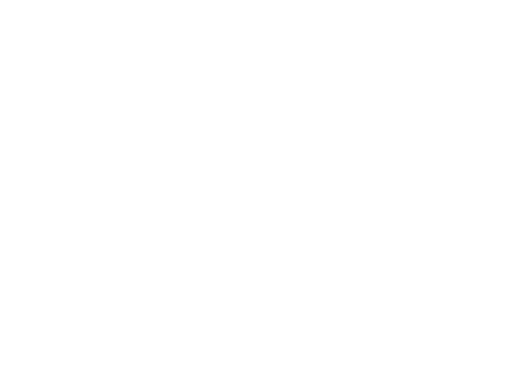

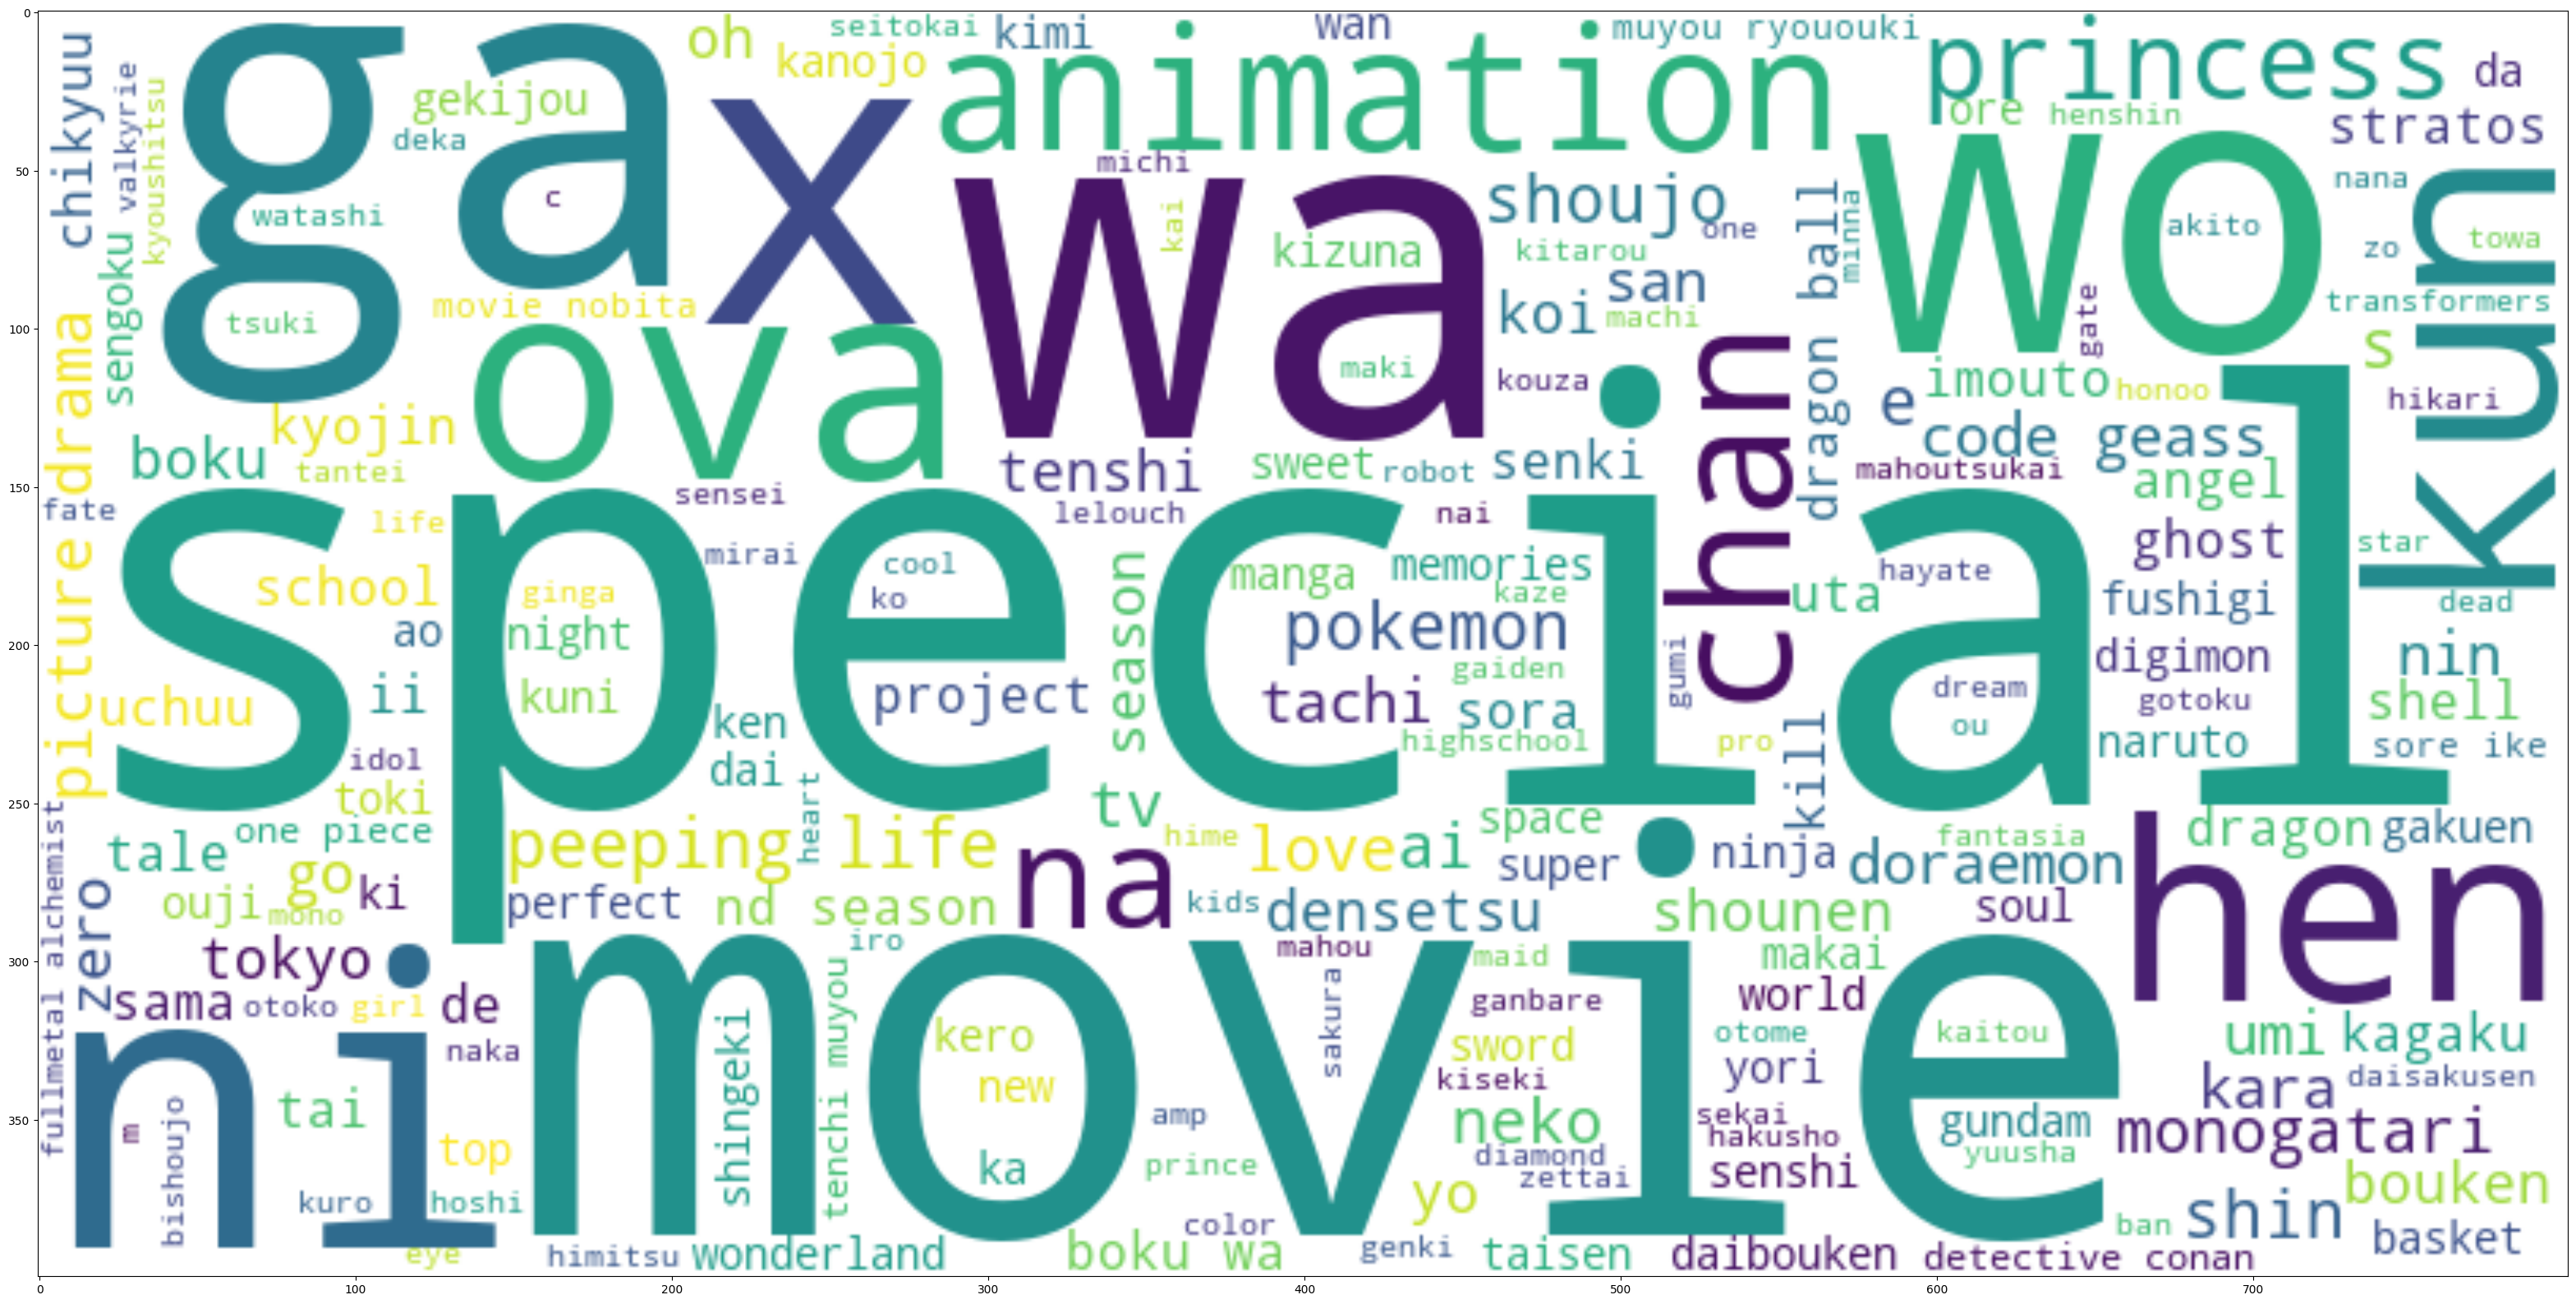

In [41]:
wordcloud = WordCloud(background_color="white", width=800, height=400)
wordcloud.generate(titles_combined)
# Disable axis display
plt.axis("off")
# Create a new figure with a specified size
plt.figure(figsize=(40,20))
# Adjust the layout to ensure tight spacing
plt.tight_layout(pad=0)
# Display the word cloud image with bilinear interpolation
plt.imshow(wordcloud, interpolation='bilinear');

In [42]:
wordcloud.to_file('anime_titles_wordcloud.png')

### combining everything

In [43]:
similarity_df=pd.DataFrame(np.zeros(shape=(anime_df.shape[0], anime_df.shape[0])))
similarity_df.columns=anime_df.anime_id
similarity_df.index=anime_df.anime_id
similarity_df

anime_id  5114   9253   820    4181   2904   199    1575   44     1      \
anime_id                                                                  
5114        0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
9253        0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
820         0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
4181        0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
2904        0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
...         ...    ...    ...    ...    ...    ...    ...    ...    ...   
18483       0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
14207       0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
18197       0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
10368       0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
26081       0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

anime_id  30276  ...  3981   9851   11825  3635   5402   18483  14207  18197  \
anime_id         ...                                                           
5114        0.0  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
9253        0.0  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
820         0.0  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
4181        0.0  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
2904        0.0  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
...         ...  ...    ...    ...    ...    ...    ...    ...    ...    ...   
18483       0.0  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
14207       0.0  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
18197       0.0  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
10368       0.0  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
26081       0.0  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

anime_id  10368  26081  
anime_id                
5114        0.0    0.0  
9253        0.0    0.0  
820         0.0    0.0  
4181        0.0    0.0  
2904        0.0    0.0  
...         ...    ...  
18483       0.0    0.0  
14207       0.0    0.0  
18197       0.0    0.0  
10368       0.0    0.0  
26081       0.0    0.0  

[1000 rows x 1000 columns]

In [45]:
def get_similarity(id_one, id_two):
    return get_genre_similarity(id_one, id_two) + get_name_similarity(id_one, id_two) + 0.5*get_type_similarity(id_one, id_two);

In [48]:
for tril_id_one, tril_id_two in zip(np.tril_indices(anime_df.shape[0], -1)[0], np.tril_indices(anime_df.shape[0], -1)[1]):
    id_one=similarity_df.columns[tril_id_one]
    id_two=similarity_df.columns[tril_id_two]
    similarity=get_similarity(id_one, id_two)
    similarity_df.at[id_one, id_two]=similarity
    similarity_df.at[id_two, id_one]=similarity

In [61]:
similarity_df=similarity_df/similarity_df.max().max()

In [62]:
similarity_df

anime_id     5114      9253      820       4181      2904      199    \
anime_id                                                               
5114      0.000000  0.210526  0.084211  0.280702  0.315789  0.093567   
9253      0.210526  0.000000  0.070175  0.210526  0.257310  0.000000   
820       0.084211  0.070175  0.000000  0.042105  0.140351  0.060150   
4181      0.280702  0.210526  0.042105  0.000000  0.242915  0.105263   
2904      0.315789  0.257310  0.140351  0.242915  0.000000  0.084211   
...            ...       ...       ...       ...       ...       ...   
18483     0.000000  0.105263  0.280702  0.000000  0.079172  0.035088   
14207     0.000000  0.000000  0.210526  0.000000  0.000000  0.000000   
18197     0.000000  0.000000  0.210526  0.000000  0.000000  0.000000   
10368     0.000000  0.000000  0.210526  0.000000  0.052632  0.060150   
26081     0.000000  0.000000  0.000000  0.000000  0.046784  0.263158   

anime_id     1575      44        1         30276  ...     3981      9851   \
anime_id                                          ...                       
5114      0.275304  0.064777  0.325359  0.238596  ...  0.000000  0.038278   
9253      0.257310  0.000000  0.263158  0.252632  ...  0.000000  0.000000   
820       0.084211  0.248804  0.157895  0.035088  ...  0.210526  0.000000   
4181      0.210526  0.070175  0.245614  0.240602  ...  0.000000  0.000000   
2904      0.842105  0.064777  0.325359  0.350877  ...  0.052632  0.084211   
...            ...       ...       ...       ...  ...       ...       ...   
18483     0.081871  0.210526  0.052632  0.042105  ...  0.392982  0.070175   
14207     0.000000  0.210526  0.000000  0.000000  ...  0.421053  0.084211   
18197     0.000000  0.210526  0.046784  0.084211  ...  0.315789  0.140351   
10368     0.060150  0.210526  0.000000  0.000000  ...  0.505263  0.084211   
26081     0.052632  0.000000  0.000000  0.000000  ...  0.280702  0.084211   

anime_id     11825     3635      5402      18483     14207     18197  \
anime_id                                                               
5114      0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
9253      0.000000  0.084211  0.000000  0.105263  0.000000  0.000000   
820       0.210526  0.350877  0.210526  0.280702  0.210526  0.210526   
4181      0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2904      0.000000  0.042105  0.000000  0.079172  0.000000  0.000000   
...            ...       ...       ...       ...       ...       ...   
18483     0.294737  0.421053  0.350877  0.000000  0.350877  0.294737   
14207     0.315789  0.315789  0.421053  0.350877  0.000000  0.315789   
18197     0.378947  0.280702  0.315789  0.294737  0.315789  0.000000   
10368     0.315789  0.315789  0.421053  0.392982  0.421053  0.315789   
26081     0.105263  0.105263  0.210526  0.178628  0.210526  0.105263   

anime_id     10368     26081  
anime_id                      
5114      0.000000  0.000000  
9253      0.000000  0.000000  
820       0.210526  0.000000  
4181      0.000000  0.000000  
2904      0.052632  0.046784  
...            ...       ...  
18483     0.392982  0.178628  
14207     0.421053  0.210526  
18197     0.315789  0.105263  
10368     0.000000  0.280702  
26081     0.280702  0.000000  

[1000 rows x 1000 columns]

In [63]:
similarity_df.to_csv("data/similarity.csv", index=True)